In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') 
%config InlineBackend.figure_format = 'svg'

## 加载数据
### 数据来源：https://www.kaggle.com/rikdifos/credit-card-approval-prediction

In [2]:
data = pd.read_csv("application_record.csv", encoding = 'utf-8') 
record = pd.read_csv("credit_record.csv", encoding = 'utf-8')  

## 数据详情

### 查看数据头几行，描述数据字段

In [3]:
# MONTHS_BALANCE:0表示当前月份，负数相对当前月份
# STATUS：0-5表示逾期越来越严重，C表示当月还清，X表示当月无贷款
record.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
# CODE_GENDER：性别
# FLAG_OWN_CAR：是否有车
# FLAG_OWN_REALTY：是否有财产
# CNT_CHILDREN：儿童数
# AMT_INCOME_TOTAL：年收入
# NAME_INCOME_TYPE：收入类别
# NAME_EDUCATION_TYPE：教育水平
# NAME_FAMILY_STATUS：婚姻状况
# NAME_HOUSING_TYPE：住房类型
# DAYS_BIRTH：生日，相对当前日期
# DAYS_EMPLOYED：开始工作日期
# FLAG_MOBIL：手机
# FLAG_WORK_PHONE：工作电话
# FLAG_PHONE：电话
# FLAG_EMAIL：邮箱
# OCCUPATION_TYPE：职位
# CNT_FAM_MEMBERS：家庭大小
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


### 改变下字段名称，便于理解

In [5]:

old=data.columns
new=['ID','gender','car','property','children_cnt','income','income_type','edu','marriage_status','house_type','birthday','work_day','mobile_phone','work_phone','phone','email','job','fam_size']
changes=dict(zip(old,new))
data.rename(columns=changes,inplace=True)

### 字段的数据类型和缺失情况

In [6]:
record.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [7]:
# job有些缺失
data.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               438557 non-null  int64  
 1   gender           438557 non-null  object 
 2   car              438557 non-null  object 
 3   property         438557 non-null  object 
 4   children_cnt     438557 non-null  int64  
 5   income           438557 non-null  float64
 6   income_type      438557 non-null  object 
 7   edu              438557 non-null  object 
 8   marriage_status  438557 non-null  object 
 9   house_type       438557 non-null  object 
 10  birthday         438557 non-null  int64  
 11  work_day         438557 non-null  int64  
 12  mobile_phone     438557 non-null  int64  
 13  work_phone       438557 non-null  int64  
 14  phone            438557 non-null  int64  
 15  email            438557 non-null  int64  
 16  job              304354 non-null  obje

### 计算用户的开户日期，作为data新的特征

In [8]:
begin_month=pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 
new_data=pd.merge(data,begin_month,how="left",on="ID")

#### 定义逾期60天及以上为危险样本

In [9]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] =='2']=1
record['dep_value'][record['STATUS'] =='3']=1
record['dep_value'][record['STATUS'] =='4']=1
record['dep_value'][record['STATUS'] =='5']=1

#### 对每个用户汇总有无逾期60天以上的情况，建立新的预测目标

In [10]:
cpunt=record.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]=1
cpunt['dep_value'][cpunt['dep_value'] == 0]=0
cpunt = cpunt[['dep_value']]
new_data=pd.merge(new_data,cpunt,how='left',on='ID')
new_data['target']=new_data['dep_value']

### target为预测特征，去除奇异值

In [11]:
new_data.target.unique()
new_data.dropna(subset=['target'],inplace=True)

#### 查看风险用户及比例
可见风险用户只有1%多点，后面需要处理数据不平衡问题

In [12]:
cpunt['dep_value'].value_counts(),cpunt['dep_value'].value_counts(normalize=True)

(0    45318
 1      667
 Name: dep_value, dtype: int64, 0    0.985495
 1    0.014505
 Name: dep_value, dtype: float64)

### 确定特征类型：
new_data.feature.value_counts()<br/>
数值：离散、连续<br/>
非数值：单类、二分类、多分类<br/><br/>
离散：children_cnt，fam_size<br/>
（准）连续：income，birthday，work_day，begin_month<br/>
单类：mobile_phone只有一种取值，对训练和预测无用<br/>
二分类：gender,car,property，work_phone，phone，email，target（预测目标）<br/>
多分类：income_type，edu，marriage_status，house_type，job<br/>
冗余：dep_value<br/>


#### 去除冗余

In [13]:
new_data.drop(columns='dep_value',axis=1,inplace=True)

#### 定义字典，记录每个特征的信息值iv

In [14]:
iv_dict=dict()

### 自定义若干方法

#### 1，计算IV值，并记录到iv_dict
#### woe：证据权重
#### iv：信息值（依赖woe）
#### WOE describes the relationship between a predictive variable and a binary target variable.
#### IV measures the strength of that relationship.
#### IV表征预测能力：小于0.02，几乎没有预测能力；小于0.1，弱；小于0.3，中等；小于0.5，强；大于0.5，难以置信，需确认

In [15]:

def cal_iv(df,feature,target='target'):
    ls=[]
    for val in df[feature].unique():
        al=df[df[feature]==val][feature].count()
        good=df[(df[feature]==val)&(df[target]==1)][feature].count()
        bad=df[(df[feature]==val)&(df[target]==0)][feature].count()
        ls.append([val,al,good,bad])
    data=pd.DataFrame(ls,columns=[feature,'all','good','bad'])
    good_rate=data['good']/data['good'].sum()# good边际概率
    bad_rate=data['bad']/data['bad'].sum()# bad边际概率
    data['woe']=np.log(good_rate/bad_rate)# woe指
    data = data.replace({'woe': {np.inf: 0, -np.inf: 0}})
    data['iv']=data['woe']*(good_rate-bad_rate)
    iv=data.iv.sum()
#     添加到字典
    if feature not in iv_dict.keys():
        iv_dict[feature]=iv
    print('iv for %s is %f: '%(feature,iv))
    return iv,data
    
        

#### 2，对变量分箱

In [16]:

def get_category(df,feature,bins,labels,right=True,quar=False):
#     等量切分
    if quar:
        df[feature+'_bin'] = pd.qcut(df[feature], q = bins, labels = labels)
#     等距切分
    else:
        df[feature+'_bin'] = pd.cut(df[feature], bins = bins, labels = labels,right=right)


### 二分类特征
#### 1，可视化
可以看到，数据不平衡问题很严重，需要一定的采样方法<br/>
数值差距较大，可视化看不出特征与target之间的关系

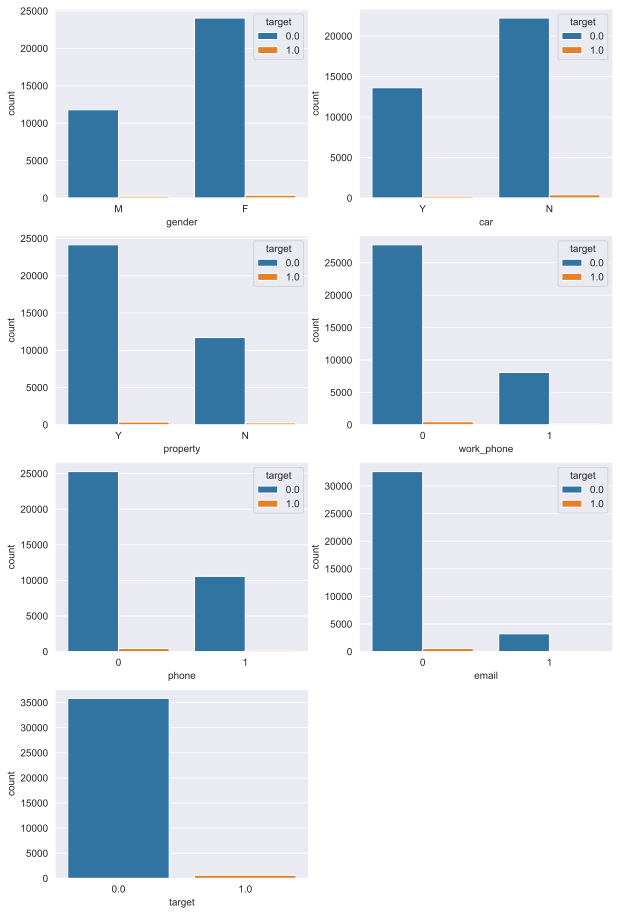

In [17]:
fig=plt.figure(figsize=(10,16))

ax1=fig.add_subplot(4,2,1)
sns.countplot(x='gender',hue='target',data=new_data)

ax2=fig.add_subplot(4,2,2)
sns.countplot(x='car',hue='target',data=new_data)

ax3=fig.add_subplot(4,2,3)
sns.countplot(x='property',hue='target',data=new_data)

ax4=fig.add_subplot(4,2,4)
sns.countplot(x='work_phone',hue='target',data=new_data)

ax5=fig.add_subplot(4,2,5)
sns.countplot(x='phone',hue='target',data=new_data)

ax6=fig.add_subplot(4,2,6)
sns.countplot(x='email',hue='target',data=new_data)

ax7=fig.add_subplot(4,2,7)
sns.countplot(x='target',data=new_data)

#### 2，计算iv值
这里只有财产具有较弱的预测能力，其他几乎没有

In [18]:
_,data=cal_iv(new_data,'gender')
data

iv for gender is 0.013581: 


,gender,all,good,bad,woe,iv
0,M,12027,237,11790,0.156654,0.008739
1,F,24430,379,24051,-0.086795,0.004842


In [19]:
_,data=cal_iv(new_data,'car')
data

iv for car is 0.001144: 


,car,all,good,bad,woe,iv
0,Y,13843,224,13619,-0.043974,0.000719
1,N,22614,392,22222,0.026025,0.000425


In [20]:
_,data=cal_iv(new_data,'property')
data

iv for property is 0.028349: 


,property,all,good,bad,woe,iv
0,Y,24506,365,24141,-0.128169,0.010385
1,N,11951,251,11700,0.221710,0.017964


In [21]:
_,data=cal_iv(new_data,'work_phone')
data

iv for work_phone is 0.001865: 


,work_phone,all,good,bad,woe,iv
0,1,8222,150,8072,0.078080,0.001428
1,0,28235,466,27769,-0.023889,0.000437


In [22]:
_,data=cal_iv(new_data,'phone')
data

iv for phone is 0.000150: 


,phone,all,good,bad,woe,iv
0,0,25709,431,25278,-0.007981,0.000045
1,1,10748,185,10563,0.018844,0.000106


In [23]:
_,data=cal_iv(new_data,'email')
data

iv for email is 0.000366: 


,email,all,good,bad,woe,iv
0,0,33186,564,32622,0.005913,0.000032
1,1,3271,52,3219,-0.061982,0.000335


### 离散变量

#### 1，可视化
数量差距大，看不出明显联系

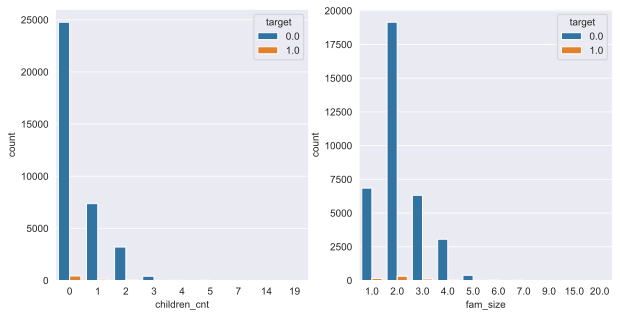

In [24]:
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,2,1)
sns.countplot(x='children_cnt',data=new_data,hue='target')
ax1.legend(loc='upper right',title='target')
ax2=fig.add_subplot(122)
sns.countplot(x='fam_size',data=new_data,hue='target')
ax2.legend(loc='upper right',title='target')

#### 2，分箱后，计算iv值

In [25]:
# children_cnt，大于3归类到3
new_data.loc[new_data['children_cnt']>3,'children_cnt']=3
# fam_size，大于4归类到4
new_data.loc[new_data['fam_size']>4,'fam_size']=4

In [26]:
get_category(new_data,'children_cnt',bins=[-1,0,1,2,3],labels=['0','1','2','3more'])

In [27]:
get_category(new_data,'fam_size',bins=[0,1,2,3,4],labels=['1','2','3','4more'])

In [28]:
_,data=cal_iv(new_data,'fam_size_bin')
data.sort_values(by='fam_size_bin')

iv for fam_size_bin is 0.007332: 


,fam_size_bin,all,good,bad,woe,iv
1,1,6987,139,6848,0.166363,0.005753
0,2,19463,313,19150,-0.050254,0.001316
3,3,6421,105,6316,-0.033280,0.000192
2,4more,3586,59,3527,-0.027065,0.000071


In [29]:
_,data=cal_iv(new_data,'children_cnt_bin')
data.sort_values(by='children_cnt_bin')

iv for children_cnt_bin is 0.004074: 


,children_cnt_bin,all,good,bad,woe,iv
0,0,25201,431,24770,0.012320,0.000106
1,1,7492,120,7372,-0.054352,0.000591
3,2,3256,52,3204,-0.057311,0.000285
2,3more,508,13,495,0.423992,0.003092


### 连续变量：income，birthday，work_day
begin_month不用，因为要预测新的用户，新用户无此特征

#### 1，预处理

In [30]:
# 缩小尺度
new_data.income=new_data.income/10000
# 转为年
new_data.birthday=new_data.birthday/(-365)
new_data.work_day=new_data.work_day/(-365)
# 奇异点处理
new_data.loc[new_data.work_day<0,'work_day']=np.nan
# 均值填充
new_data.work_day.fillna(new_data.work_day.mean(),axis=0,inplace=True)
# 重命名
new_data.rename(inplace=True,columns={'birthday':'age','work_day':'work_year'})

#### 2，可视化展示

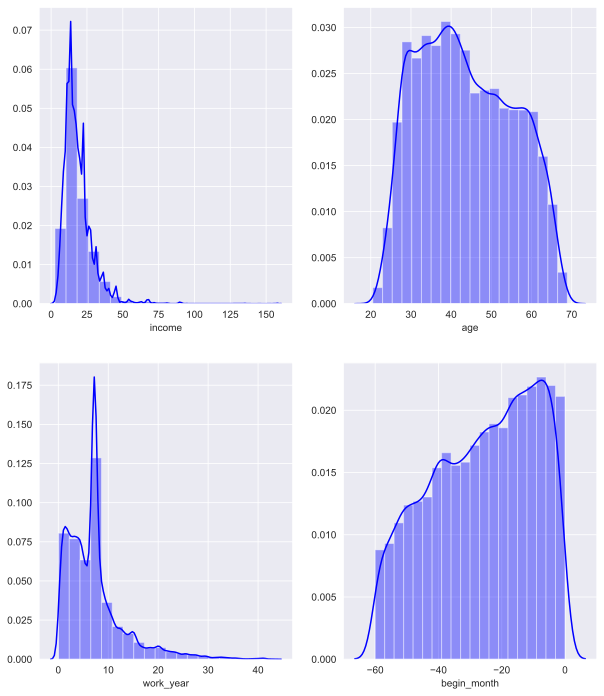

In [31]:
fig=plt.figure(figsize=(10,12))
ax1=fig.add_subplot(221)
sns.distplot(new_data.income,bins=20,color='blue')
ax2=fig.add_subplot(222)
sns.distplot(new_data.age,bins=20,color='blue')
ax3=fig.add_subplot(223)
sns.distplot(new_data.work_year,bins=20,color='blue')
ax4=fig.add_subplot(224)
sns.distplot(new_data.begin_month,bins=20,color='blue')

#### 3，分箱，计算iv值
从可视化看，income使用等量划分，因为数据太过集中在一端<br/>
这里只有工作年限有弱的预测能力

In [32]:
# 等量划分
get_category(new_data,'income',bins=3,labels=['1','2','3'],quar=True)

# 等距划分
# 分细一点，因为这2个特征比较有用
get_category(new_data,'age',bins=5,labels=['1','2','3','4','5'])
get_category(new_data,'work_year',bins=5,labels=['1','2','3','4','5'])

In [33]:
_,data=cal_iv(new_data,'income_bin')
data.sort_values(by='income_bin')

iv for income_bin is 0.003572: 


,income_bin,all,good,bad,woe,iv
1,1,14473,257,14216,0.050554,0.001040
2,2,10702,165,10537,-0.093102,0.002433
0,3,11282,194,11088,0.017840,0.000099


In [34]:
_,data=cal_iv(new_data,'age_bin')
data.sort_values(by='age_bin')

iv for age_bin is 0.012024: 


,age_bin,all,good,bad,woe,iv
4,1,5129,104,5025,0.185811,0.005320
0,2,10099,159,9940,-0.071817,0.001380
3,3,9078,139,8939,-0.100104,0.002378
1,4,7647,143,7504,0.103254,0.002351
2,5,4504,71,4433,-0.070551,0.000594


In [35]:
_,data=cal_iv(new_data,'work_year_bin')
data.sort_values(by='work_year_bin')

iv for work_year_bin is 0.027081: 


,work_year_bin,all,good,bad,woe,iv
1,1,27389,501,26888,0.080772,0.005097
0,2,6606,87,6519,-0.252967,0.010284
2,3,1804,23,1781,-0.285835,0.003531
3,4,528,4,524,-0.811597,0.006596
4,5,130,1,129,-0.796212,0.001573


### 多分类变量：income_type，edu，marriage_status，house_type，job

#### 1，可视化
从收入图表看，除了学生类只有11个样本，其他分布都比较类似

##### 收入类型

In [36]:
new_data.income_type.value_counts()

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: income_type, dtype: int64

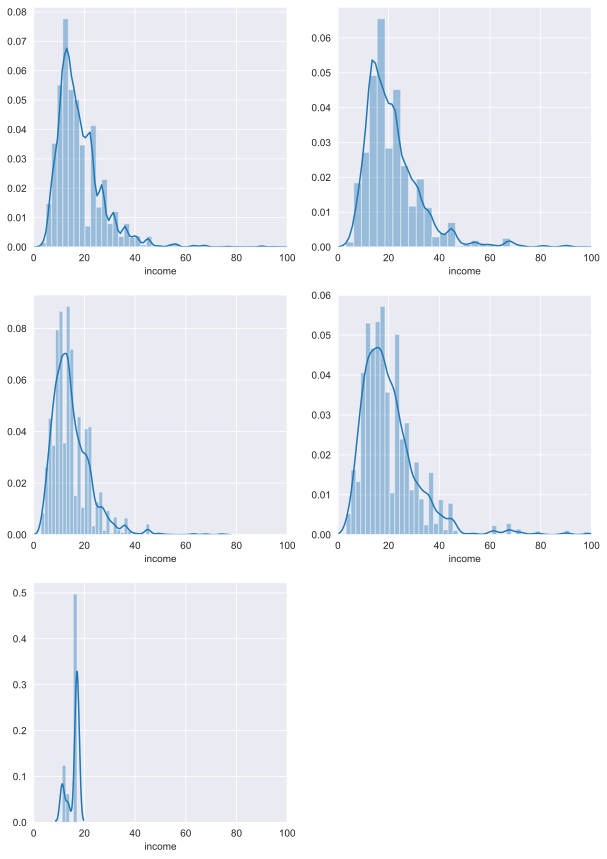

In [37]:
fig=plt.figure(figsize=(10,15))
ax1=fig.add_subplot(321)
ax1.set_xlim(0,100)
sns.distplot(new_data[new_data.income_type=='Working']['income'])
ax2=fig.add_subplot(322)
ax2.set_xlim(0,100)
sns.distplot(new_data[new_data.income_type=='Commercial associate']['income'])
ax3=fig.add_subplot(323)
ax3.set_xlim(0,100)
sns.distplot(new_data[new_data.income_type=='Pensioner']['income'])
ax4=fig.add_subplot(324)
ax4.set_xlim(0,100)
sns.distplot(new_data[new_data.income_type=='State servant']['income'])
ax5=fig.add_subplot(325)
ax5.set_xlim(0,100)
sns.distplot(new_data[new_data.income_type=='Student']['income'])

In [38]:
# 学生和养老的分一组，其他保留
new_data.loc[new_data.income_type.isin(['Pensioner','Student']),'income_type']=1
new_data.loc[new_data.income_type=='Working','income_type']=2
new_data.loc[new_data.income_type=='State servant','income_type']=3
new_data.loc[new_data.income_type=='Commercial associate','income_type']=4

In [39]:
_,data=cal_iv(new_data,'income_type')
data

iv for income_type is 0.017408: 


,income_type,all,good,bad,woe,iv
0,2,18819,306,18513,-0.039043,0.000772
1,4,8490,143,8347,-0.003212,0.000002
2,1,6163,130,6033,0.226136,0.009659
3,3,2985,37,2948,-0.314364,0.006975


##### 教育程度

In [40]:
new_data.edu.value_counts()

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: edu, dtype: int64

In [41]:
# 高等教育、学位教育分一组，中学分一组，高等教育辍学分一组
new_data.loc[new_data.edu.isin(['Secondary / secondary special','Lower secondary']),'edu']=1
new_data.loc[new_data.edu=='Incomplete higher','edu']=2
new_data.loc[new_data.edu.isin(['Higher education','Academic degree']),'edu']=3

In [42]:
_,data=cal_iv(new_data,'edu')
data.sort_values('edu')

iv for edu is 0.005855: 


,edu,all,good,bad,woe,iv
1,1,25151,412,24739,-0.031512,0.000675
2,2,1410,33,1377,0.332446,0.005037
0,3,9896,171,9725,0.022809,0.000143


##### 婚姻状态
有弱的预测能力

In [43]:
new_data.marriage_status.value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: marriage_status, dtype: int64

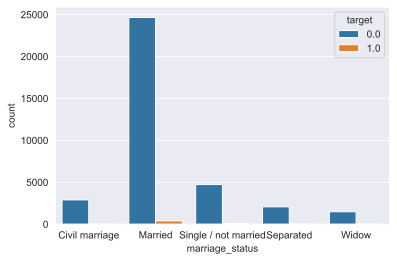

In [44]:
# 比例太低，看不清楚
sns.countplot(x='marriage_status',data=new_data,hue='target')

In [45]:
_,data=cal_iv(new_data,'marriage_status')
data

iv for marriage_status is 0.030119: 


,marriage_status,all,good,bad,woe,iv
0,Civil marriage,2945,46,2899,-0.079879,0.000496
1,Married,25048,393,24655,-0.075325,0.003760
2,Single / not married,4829,101,4728,0.217464,0.006969
3,Separated,2103,31,2072,-0.138682,0.001038
4,Widow,1532,45,1487,0.565747,0.017857


##### 住房类型

In [46]:
new_data.house_type.value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: house_type, dtype: int64

In [47]:
_,data=cal_iv(new_data,'house_type')
data

iv for house_type is 0.015711: 


,house_type,all,good,bad,woe,iv
0,Rented apartment,575,8,567,-0.197317,0.000559
1,House / apartment,32548,540,32008,-0.018571,0.000305
2,Municipal apartment,1128,30,1098,0.463553,0.008375
3,With parents,1776,26,1750,-0.145674,0.000964
4,Co-op apartment,168,3,165,0.056268,0.000015
5,Office apartment,262,9,253,0.727436,0.005493


##### 工作岗位

In [48]:
new_data.job.value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: job, dtype: int64

In [49]:
# 缺失当做一组
new_data.job.fillna('unknown',inplace=True,axis=0)

In [50]:
# 加上unknown，总共4组
new_data.loc[new_data['job'].isin(['Cleaning staff','Cooking staff','Drivers','Laborers','Low-skill Laborers','Security staff','Waiters/barmen staff']),'job']='Laborwk'
new_data.loc[new_data['job'].isin(['Accountants','Core staff','HR staff','Medicine staff','Private service staff','Realty agents','Sales staff','Secretaries']),'job']='officewk'
new_data.loc[new_data['job'].isin(['Managers','High skill tech staff','IT staff']),'job']='hightecwk'

In [51]:
_,data=cal_iv(new_data,'job')
data

iv for job is 0.003404: 


,job,all,good,bad,woe,iv
0,unknown,11323,194,11129,0.014149,0.000063
1,Laborwk,10496,185,10311,0.042990,0.000543
2,officewk,10183,157,10026,-0.093090,0.002315
3,hightecwk,4455,80,4375,0.061966,0.000484


### 至此，各种变量可视化和iv值计算完毕

#### 可视化iv值排名

In [52]:
# iv字典按值逆序排序
sort_ivdict=dict(sorted(iv_dict.items(),key=lambda x:x[1],reverse=True))
sort_ivdict

{'marriage_status': 0.030119259773091364,
 'property': 0.028349157710111456,
 'work_year_bin': 0.02708125257484757,
 'income_type': 0.017408188444095824,
 'house_type': 0.015711059499443562,
 'gender': 0.01358137166735823,
 'age_bin': 0.01202392527343905,
 'fam_size_bin': 0.007332472891451862,
 'edu': 0.005854653578451454,
 'children_cnt_bin': 0.004074453969659672,
 'income_bin': 0.0035723740220329463,
 'job': 0.0034041482375801067,
 'work_phone': 0.0018649623862678107,
 'car': 0.0011443033795676995,
 'email': 0.00036647741069788757,
 'phone': 0.0001503891689122608}

#### 可以看到，只有3个特征具有弱的预测能力

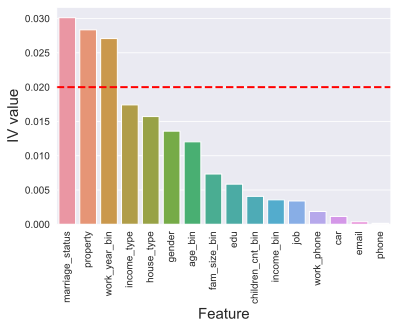

In [53]:
# 可视化各特征的iv值
sns.barplot(x=list(sort_ivdict.keys()),y=list(sort_ivdict.values()))
plt.xlabel('Feature',fontsize=15)
plt.ylabel('IV value',fontsize=15)
plt.xticks(rotation=90)
plt.axhline(y=0.02,ls="--",c="red",lw=2)
plt.show()

### 特征处理与筛选

#### 去除不用的特征

In [54]:
drop_cols=['ID','children_cnt','income','fam_size','age','work_year','begin_month','mobile_phone']
new_data.drop(columns=drop_cols,axis=1,inplace=True)
new_data.columns

Index(['gender', 'car', 'property', 'income_type', 'edu', 'marriage_status',
       'house_type', 'work_phone', 'phone', 'email', 'job', 'target',
       'children_cnt_bin', 'fam_size_bin', 'income_bin', 'age_bin',
       'work_year_bin'],
      dtype='object')

#### 二分类转换为0,1

In [55]:
new_data.gender=new_data.gender.replace({'M':1,'F':0})
new_data.car=new_data.car.replace({'Y':1,'N':0})
new_data.property=new_data.property.replace({'Y':1,'N':0})

In [56]:
# 检查其他二分类已0/1化
new_data.work_phone.unique(),new_data.phone.unique(),new_data.email.unique()

(array([1, 0], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64))

#### 每个多分类转换为多列

In [57]:
dummy_cols=['income_type','edu','marriage_status','house_type','job','children_cnt_bin','fam_size_bin','income_bin','age_bin','work_year_bin']
data=pd.get_dummies(new_data,columns=dummy_cols)
data

,gender,car,property,work_phone,phone,email,target,income_type_1,income_type_2,income_type_3,...,age_bin_1,age_bin_2,age_bin_3,age_bin_4,age_bin_5,work_year_bin_1,work_year_bin_2,work_year_bin_3,work_year_bin_4,work_year_bin_5
0,1,1,1,1,0,0,0.0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,1,1,1,1,0,0,0.0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0.0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,1,0,1,1,0.0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,1,0,1,1,0.0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434808,1,1,1,0,0,0,1.0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
434809,0,0,1,0,1,1,1.0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
434810,0,0,1,0,1,1,1.0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
434811,0,0,1,0,0,0,1.0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


#### 提取训练特征和预测目标

In [58]:
# float改为int
data.target=data.target.astype('int')

X=data.drop(columns='target',axis=1).values
Y=data.target.values

### 使用过采样解决数据平衡问题

In [59]:
data.target.value_counts()

0    35841
1      616
Name: target, dtype: int64

In [60]:
from imblearn import over_sampling

X_balanced,Y_balanced=over_sampling.SMOTE().fit_sample(X,Y)

# 采样后大于原始样本数，target已经平衡了
len(X_balanced),len(X),Y_balanced.sum()

(71682, 36457, 35841)

### 评价标准：精度、f1得分
#### 自定义函数可视化结果

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

In [62]:
# 利用seaborn热图绘制混淆矩阵
def plot_confu(y_true,y_pred,labels=[0,1]):
    c=confusion_matrix(y_true,y_pred,labels=labels)# 混淆矩阵
    a=c/c.sum(axis=1)# 百分比形式
    df=pd.DataFrame(a,index=['0','1'],columns=['0','1'])# 转为DataFrame
    sns.heatmap(df,annot=True,cmap='YlGnBu')# 直接利用热图
    plt.title('Confusion Matrix')
    plt.xlabel('Predict',fontsize=15)
    plt.ylabel('True',fontsize=15)

In [63]:
# 打印精度和f1得分
def print_score(y_true,y_pred):
    accuracy=accuracy_score(y_true,y_pred)*100
    f_score=f1_score(y_true,y_pred)
    print('accuracy is %.3f%%, f1_score is %.6f'%(accuracy,f_score))

### 分割训练集和测试集

In [64]:
X_train,X_test,y_train,y_test=train_test_split(X_balanced,Y_balanced,random_state=11,test_size=0.3)

### 不同模型评估对比

#### 逻辑回归：效果一般

In [65]:
from sklearn.linear_model import LogisticRegression

accuracy is 84.492%, f1_score is 0.822427


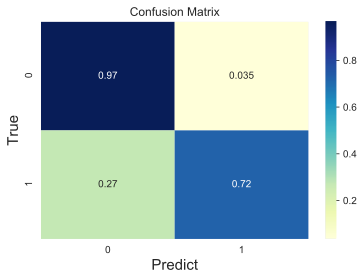

In [66]:
lr=LogisticRegression(n_jobs=-1)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

#### SVC：对比线性核和rbf核，可以发现线性模型的表现一般，这是因为线性核要求woe的单调性

In [67]:
from sklearn.svm import SVC

accuracy is 83.348%, f1_score is 0.798583


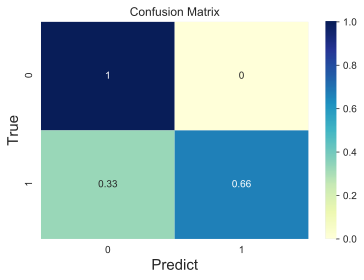

In [68]:
# 线性核
svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

accuracy is 95.550%, f1_score is 0.954775


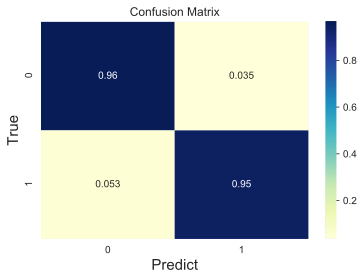

In [69]:
# rbf核
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

#### LGBMClassifier：秒速运行完，精度也很好

accuracy is 95.141%, f1_score is 0.950914


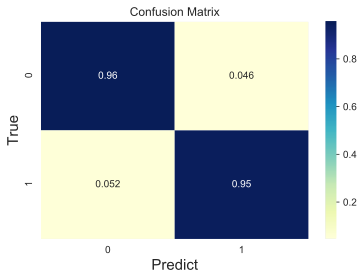

In [70]:
from lightgbm import LGBMClassifier
clf=LGBMClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

##### 可视化特征重要性

In [71]:
# 绘制特征重要性估值，返回最重要的3个特征
def plot_importance(clf):
    imp=clf.feature_importances_
    idx=np.argsort(imp)
    cols=data.columns[idx]
    vals=imp[idx]
    sns.barplot(x=cols,y=vals)
    plt.xlabel('Feature',fontsize=15)
    plt.ylabel('Importance value',fontsize=15)
    plt.xticks(rotation=90)
    plt.show()
    print('the most three important features are ',list(cols[-3:][::-1]))

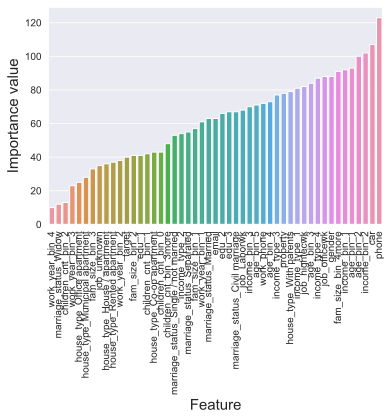

the most three important features are  ['phone', 'car', 'income_bin_2']


In [72]:
features=plot_importance(clf)

#### 决策树

In [73]:
from sklearn.tree import DecisionTreeClassifier

accuracy is 96.503%, f1_score is 0.965004


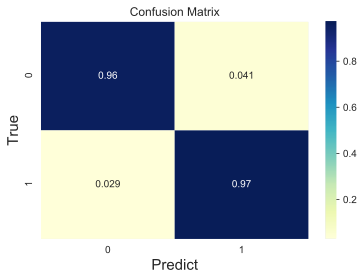

In [74]:
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

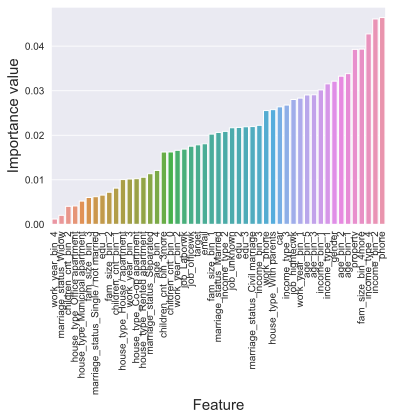

the most three important features are  ['phone', 'income_bin_2', 'income_type_4']


In [75]:
plot_importance(clf)

#### 随机森林

In [76]:
from sklearn.ensemble import RandomForestClassifier

accuracy is 96.717%, f1_score is 0.967065


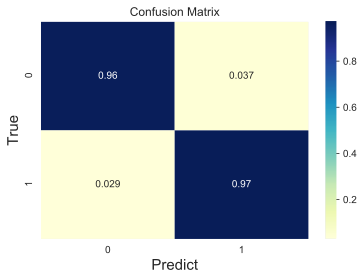

In [77]:
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

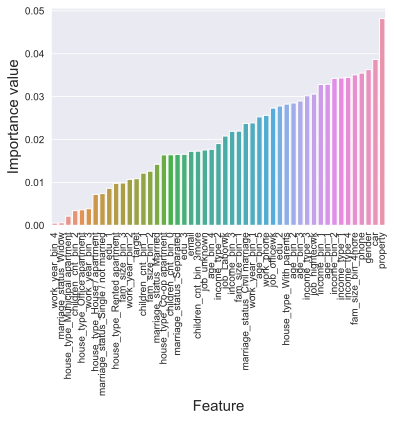

the most three important features are  ['property', 'car', 'gender']


In [78]:
plot_importance(clf)

#### XGBClassifier：和随机森林高度相似

In [79]:
from xgboost import XGBClassifier

accuracy is 96.750%, f1_score is 0.967378


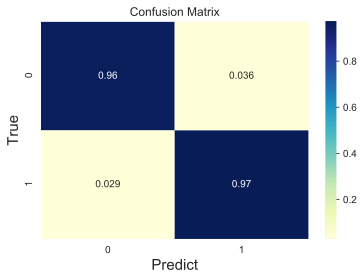

In [80]:
clf=XGBClassifier()
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print_score(y_test,y_pred)
plot_confu(y_test,y_pred)

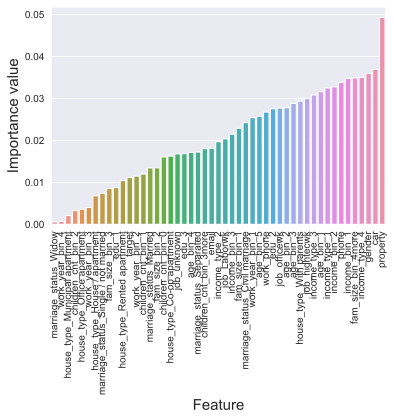

the most three important features are  ['property', 'car', 'gender']


In [81]:
plot_importance(clf)

#### 使用Keras框架构建神经网络
也还行，不过这里没必要用神经网络

In [82]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.optimizers import adam

Using TensorFlow backend.


In [83]:
model=Sequential()
model.add(Dense(64,activation='relu',input_shape=(len(X_train[0]),)))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=adam(),loss='binary_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [84]:
history = model.fit(X_train, y_train,
    epochs = 64,
    batch_size = 128,
    validation_split=0.3,verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 35123 samples, validate on 15054 samples
Epoch 1/64
 - 5s - loss: 0.3915 - accuracy: 0.8212 - val_loss: 0.9014 - val_accuracy: 0.6398
Epoch 2/64
 - 2s - loss: 0.1786 - accuracy: 0.9308 - val_loss: 0.2005 - val_accuracy: 0.9122
Epoch 3/64
 - 2s - loss: 0.1411 - accuracy: 0.9459 - val_loss: 0.1378 - val_accuracy: 0.9500
Epoch 4/64
 - 2s - loss: 0.1242 - accuracy: 0.9530 - val_loss: 0.1326 - val_accuracy: 0.9531
Epoch 5/64
 - 2s - loss: 0.1197 - accuracy: 0.9539 - val_loss: 0.1292 - val_accuracy: 0.9524
Epoch 6/64
 - 2s - loss: 0.1145 - accuracy: 0.9549 - val_loss: 0.1219 - val_accuracy: 0.9585
Epoch 7/64
 - 3s - loss: 0.1089 - accuracy: 0.9581 - val_loss: 0.1342 - val_accuracy: 0.9535
Epoch 8/64
 - 2s - loss: 0.1053 - accuracy: 0.9600 - val_loss: 0.1337 - val_accuracy: 0.9504
Epoch 9/64
 - 2s - loss: 0.1034 - accuracy: 0.9596 - val_loss: 0.1084 - val_accuracy: 0.9612
Epoch 10/64
 - 2s - loss: 0.0998 - accuracy: 0.9607 - val_loss: 0

In [85]:
his=history.history
acc=his['accuracy']
val_acc=his['val_accuracy']
epochs=range(1,len(acc)+1)
df=pd.DataFrame({'epochs':epochs,'acc':acc,'val_acc':val_acc})
# 熔化，将多个列合并到一列中
df=pd.melt(df,id_vars=['epochs'],value_vars=['acc','val_acc'])

##### 可视化训练情况，观察过拟合行为
plotnine允许使用R风格ggplot绘图<br/>
从图中可知，大概10轮左右在验证集上开始出现过拟合

In [86]:
from plotnine import *

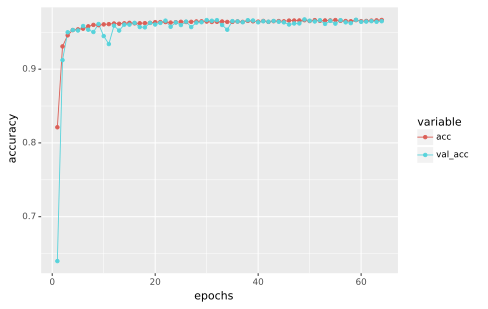

<ggplot: (-9223371878470828196)>

In [87]:
(
ggplot(df,aes('epochs','value',color = 'variable'))+
    geom_line()+geom_point()+labs(y='accuracy')
)

##### 不分验证集，再训练一遍，使用略大于之前过拟合（10）的训练轮数（15）

In [88]:
model=Sequential()
model.add(Dense(64,activation='relu',input_shape=(len(X_train[0]),)))
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer=adam(),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train, y_train,
    epochs = 15,
    batch_size = 128,verbose=2)

Epoch 1/15
 - 3s - loss: 0.3147 - accuracy: 0.8634
Epoch 2/15
 - 3s - loss: 0.1474 - accuracy: 0.9443
Epoch 3/15
 - 3s - loss: 0.1252 - accuracy: 0.9510
Epoch 4/15
 - 3s - loss: 0.1154 - accuracy: 0.9567
Epoch 5/15
 - 3s - loss: 0.1083 - accuracy: 0.9585
Epoch 6/15
 - 3s - loss: 0.1044 - accuracy: 0.9605
Epoch 7/15
 - 3s - loss: 0.1012 - accuracy: 0.9613
Epoch 8/15
 - 3s - loss: 0.0984 - accuracy: 0.9622
Epoch 9/15
 - 3s - loss: 0.0969 - accuracy: 0.9624
Epoch 10/15
 - 3s - loss: 0.0951 - accuracy: 0.9631
Epoch 11/15
 - 3s - loss: 0.0951 - accuracy: 0.9629
Epoch 12/15
 - 3s - loss: 0.0925 - accuracy: 0.9637
Epoch 13/15
 - 3s - loss: 0.0927 - accuracy: 0.9635
Epoch 14/15
 - 3s - loss: 0.0899 - accuracy: 0.9639
Epoch 15/15
 - 3s - loss: 0.0898 - accuracy: 0.9642


accuracy is 96.233%, f1_score is 0.961764


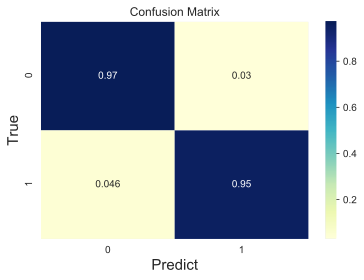

In [89]:
# 先展开数组
y_pred=model.predict(X_test)[:,0]
# 再四舍五入
y=np.around(y_pred,0).astype('int')

print_score(y_test,y)
plot_confu(y_test,y)

In [90]:
# 直接使用evaluate方法可以方便地计算精度
model.evaluate(X_test,y_test)

21505/21505 [==============================] - 2s 71us/step


[0.10702453444247827, 0.9623343348503113]